In [156]:
# Thanks to Senshin @ https://stackoverflow.com/a/33947673/706797
def get_first_sig_dig(x):
    from math import log10, floor
    return round(x / (10**floor(log10(x))))

# Thanks to Evgeny and Tobias Kienzler @ https://stackoverflow.com/a/3411435/706797
def round_to_1(x):
    from math import log10, floor
    return round(x, -int(floor(log10(abs(x)))))

def refit_step(step_tick, num_steps, max_width_in_units, min_step_width_in_pixels, units_per_pixel):
    sig_dig = get_first_sig_dig(step_tick)
    if num_steps > 1:
        step_tick = increase_step_size(step_tick, sig_dig)
        num_steps = int(max_width_in_units/step_tick)
    else:
        step_tick = reduce_step_size(step_tick, sig_dig)
        num_steps = int(max_width_in_units/step_tick)
            
    step_width_in_pixels = step_tick/units_per_pixel
    if step_width_in_pixels < min_step_width_in_pixels:
        growth_ratio = int(min_step_width_in_pixels/step_width_in_pixels)+1
        step_tick = step_tick * growth_ratio
        num_steps = int(max_width_in_units/step_tick)
    
    if num_steps < 1:
        # punt and worry about other things.
        step_tick = min_step_width_in_pixels * units_per_pixel
        num_steps = 1
        
    if step_tick > 10:
        step_tick = int(step_tick)

    return {
        'step_tick': step_tick,
        'num_steps': num_steps
    }

def increase_step_size(step_tick, sig_dig):
    if sig_dig in [1,2,5]:
        return step_tick
    elif sig_dig < 5:
        resize_factor = 5/sig_dig
    else:
        resize_factor = 10/sig_dig
            
    new_step_tick = resize_factor * step_tick
    return resize_factor * step_tick

def reduce_step_size(step_tick, sig_dig):
    if sig_dig < 3:
        resize_factor = 0.5
    elif sig_dig < 5:
        resize_factor = 2/sig_dig
    elif sig_dig == 5:
        return step_tick
    else:
        resize_factor = 5/sig_dig
        
    return step_tick * resize_factor
    
def generate_scalebar_ticks(img_width_in_meters, img_width_in_pixels=509, scale_width_ratio=1, min_step_width=100, dpi=300):
    meters_per_pixel = img_width_in_meters/img_width_in_pixels
    units_bottom = 'meters'
    scale_bottom = 1
    units_top = 'feet'
    scale_top = 0.3048
    scale_width_in_meters = img_width_in_meters*scale_width_ratio
    scale_width_in_pixels = scale_width_in_meters/meters_per_pixel
    max_step_count = int(scale_width_in_pixels/min_step_width)
    num_steps_bottom = max_step_count
    if num_steps_bottom < 1:
        num_steps_bottom = 1
    if scale_width_in_meters/num_steps_bottom > 1000:
        units_bottom = 'km'
        scale_bottom = 1000
        units_top = 'miles'
        scale_top = 1609.34
    bottom_unit_count = scale_width_in_meters/scale_bottom
    top_unit_count = scale_width_in_meters/scale_top
    step_ticks_bottom = round_to_1(bottom_unit_count/num_steps_bottom)
    
    refit_dict = refit_step(
        step_ticks_bottom, 
        num_steps_bottom, 
        scale_width_in_meters/scale_bottom, 
        min_step_width, 
        meters_per_pixel/scale_bottom
    )
    step_ticks_bottom = refit_dict['step_tick']
    num_steps_bottom = refit_dict['num_steps']
    
    step_ticks_top = round_to_1(top_unit_count/num_steps_bottom)
    num_steps_top = num_steps_bottom
    
    refit_dict = refit_step(
        step_ticks_top, 
        num_steps_top, 
        scale_width_in_meters/scale_top, 
        min_step_width, 
        meters_per_pixel/scale_top
    )
    
    step_ticks_top = refit_dict['step_tick']
    num_steps_top = refit_dict['num_steps']
    
    num_ticks_top = num_steps_top + 1
    num_ticks_bottom = num_steps_bottom + 1
    
    return make_scalebar(
        num_ticks_top,
        step_ticks_top,
        num_ticks_bottom,
        step_ticks_bottom,
        meters_per_pixel,
        scale_top=scale_top,
        scale_bottom=scale_bottom,
        units_top=units_top,
        units_bottom=units_bottom,
        dpi=dpi
    )

def format_label(value):
    if int(value) >= 1000:
        return '{:,d}'.format(value)
    # elif type(value) == int or value >= 10:
    #     return str(int(value))
    else:
        # 3 digits should be more than enough - in theory there should only be 1 unless things go sideways
        return '{:.3g}'.format(value)
    

def make_scalebar(num_ticks_top, step_ticks_top, 
                  num_ticks_bottom, step_ticks_bottom,
                  meters_per_pixel=None,
                  scale_top=1.0, 
                  scale_bottom=3.28084,
                  units_top='feet', units_bottom='meters', dpi=200):
    """Generates a dual scale bar and writes it to disk as a png that 
    is ten inches wide and one inch tall at 200 pixels per inch 
    (output image is 2000 pixels wide x 200 pixels tall).
    Parameters
    ----------
    num_ticks_top, num_ticks_bottom : int
      number of ticks, including starting and ending points, to use for drawing scale bars
    step_ticks_top, step_ticks_bottom : numeric
      amount that each successive tick adds to previous tick
    outfile : str
      path to output file that will be generated
    scale_top, scale_bottom : numeric
      relative scales of units in top and bottom scale bars
    units_top, units_bottom : str    
      string used to label units on the last tick in the scale bar
    dpi : int
    """
    import matplotlib
    matplotlib.use('Agg')  # this specifies a "back-end" for matplotlib so that it doesn't attempt to display the figure when you save it
    from matplotlib import pyplot as plt
    import numpy as np
        
    width_top = (num_ticks_top-1) * scale_top * step_ticks_top/step_ticks_bottom
    width_bot = (num_ticks_bottom-1) * scale_bottom
    min_top, max_top = -width_top / 2, width_top / 2
    min_bot, max_bot = -width_bot / 2, width_bot / 2
    fig = plt.figure(frameon=False)
    # TODO: need to calculate width based on pixels and DPI
    fig.set_size_inches(10,1)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.plot((min_top,max_top), (1.0, 1.0), lw=0.5, color='black')
    ticks = np.linspace(min_top, max_top, num_ticks_top)
    for i, x in enumerate(ticks):
        ax.plot((x, x), (1.0, 3.0), lw=0.5, color='black')
        ax.text(x, 4.0, format_label(step_ticks_top*i),
                horizontalalignment='center',
                verticalalignment='bottom', 
                fontname='arial')
        if x == ticks[-1]:
            spaces = ' ' * (len(format_label(step_ticks_top*i))+1)
            ax.text(x, 4.0, spaces + units_top,
                    horizontalalignment='left',
                    verticalalignment='bottom', 
                    fontname='arial')
    ax.plot((min_bot,max_bot), (-1,-1), lw=0.5, color='black')
    ticks = np.linspace(min_bot, max_bot, num_ticks_bottom)
    for i, x in enumerate(ticks):
        ax.plot((x, x), (-1.0, -3.0), lw=0.5, color='black')
        ax.text(x, -4.0, format_label(step_ticks_bottom*i),
                horizontalalignment='center',
                verticalalignment='top', 
                fontname='arial')
        if x == ticks[-1]:
            spaces = ' ' * (len(format_label(step_ticks_bottom*i))+1)
            ax.text(x, -4.0, spaces + units_bottom,
                    horizontalalignment='left',
                    verticalalignment='top', 
                    fontname='arial')
    ax.set_ylim(-10,10)
    ax.axis('off')
    return plt_to_pil_image(fig, dpi)

def plt_to_pil_image(plt_figure, dpi=200):
    import io
    from PIL import Image
    import matplotlib.pyplot as plt

    fig = plt.figure(plt_figure.number)
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=dpi)
    buf.seek(0)
    pil_image = Image.open(buf)
    # buf.close()
    return pil_image

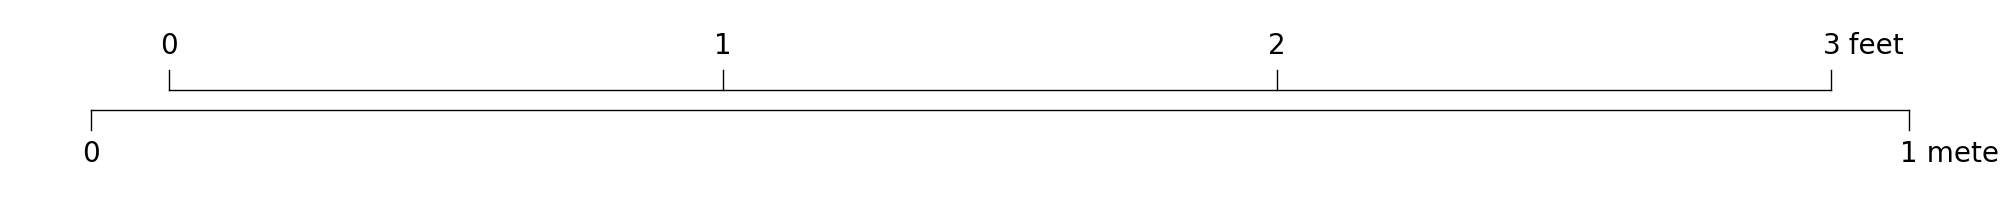

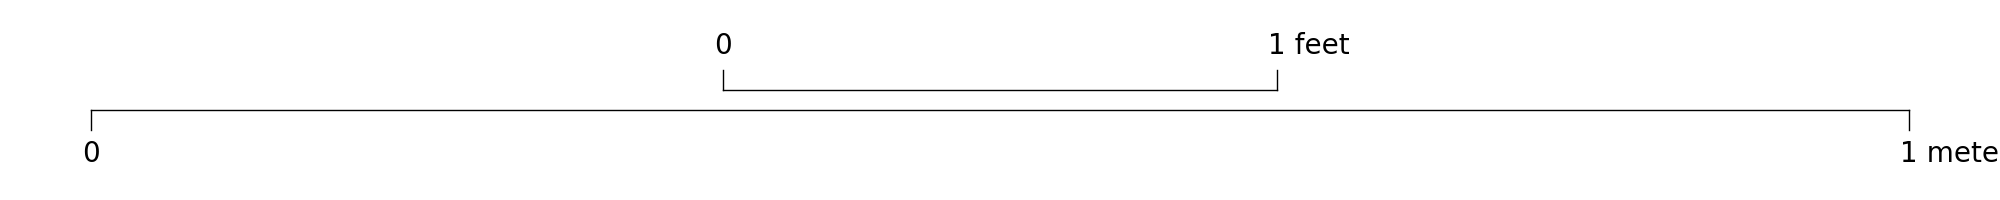

3 meters across 500 pixels


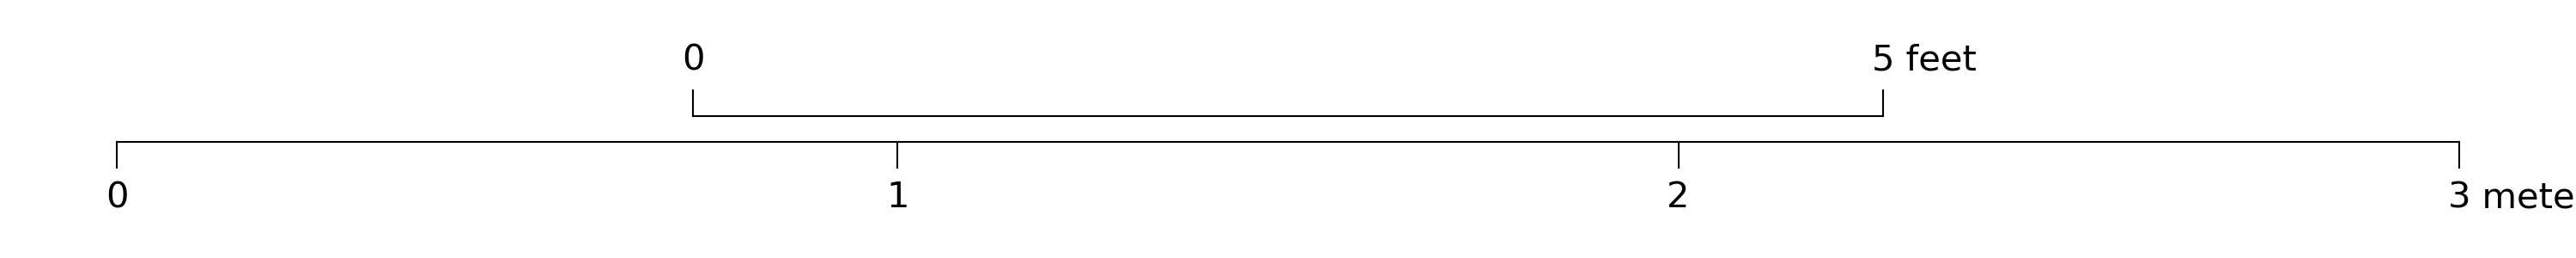

1000 meters across 500 pixels


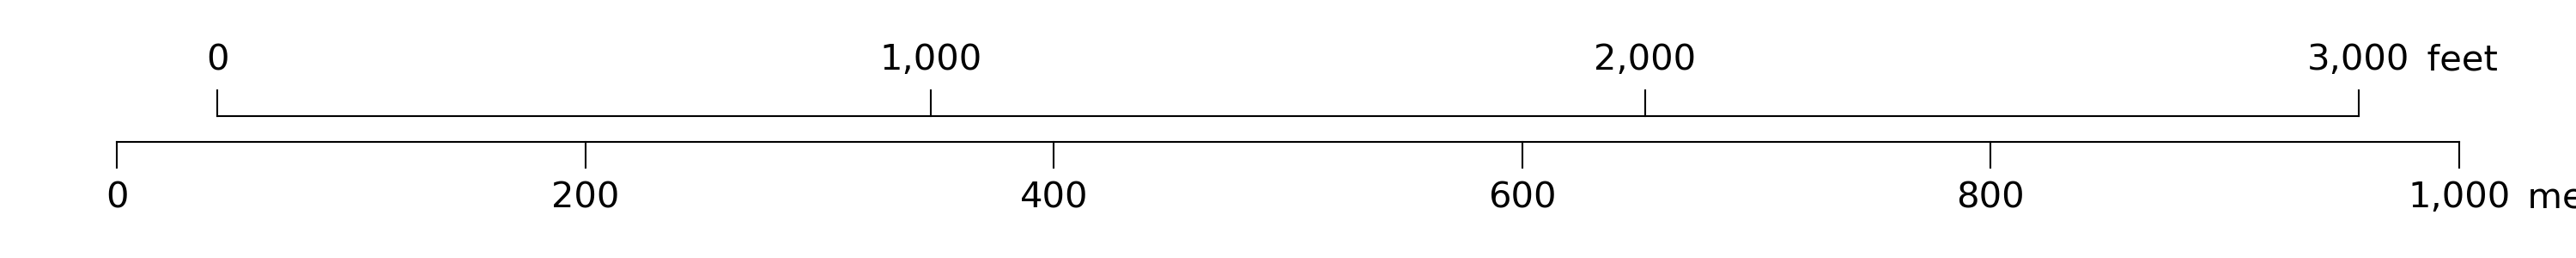

4999 meters across 500 pixels


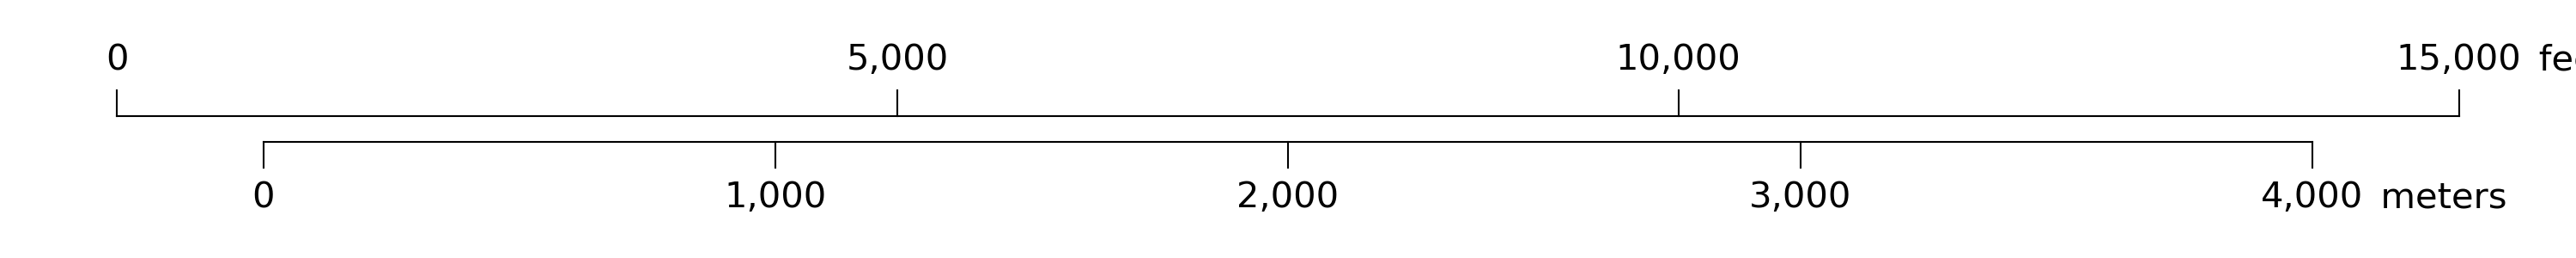

5000 meters across 500 pixels


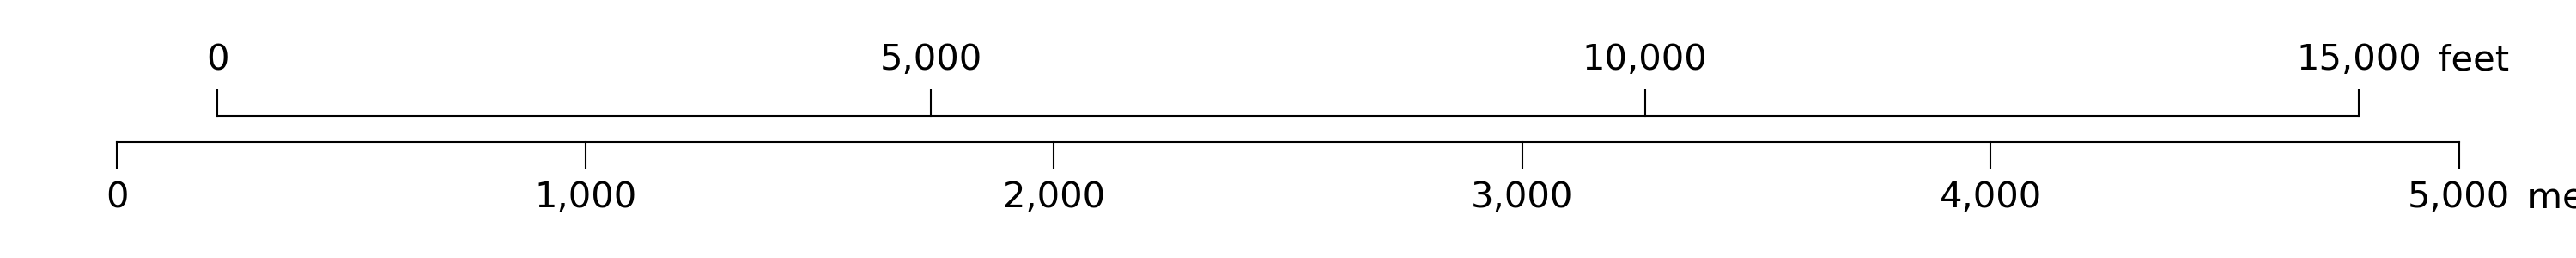

6000 meters across 500 pixels


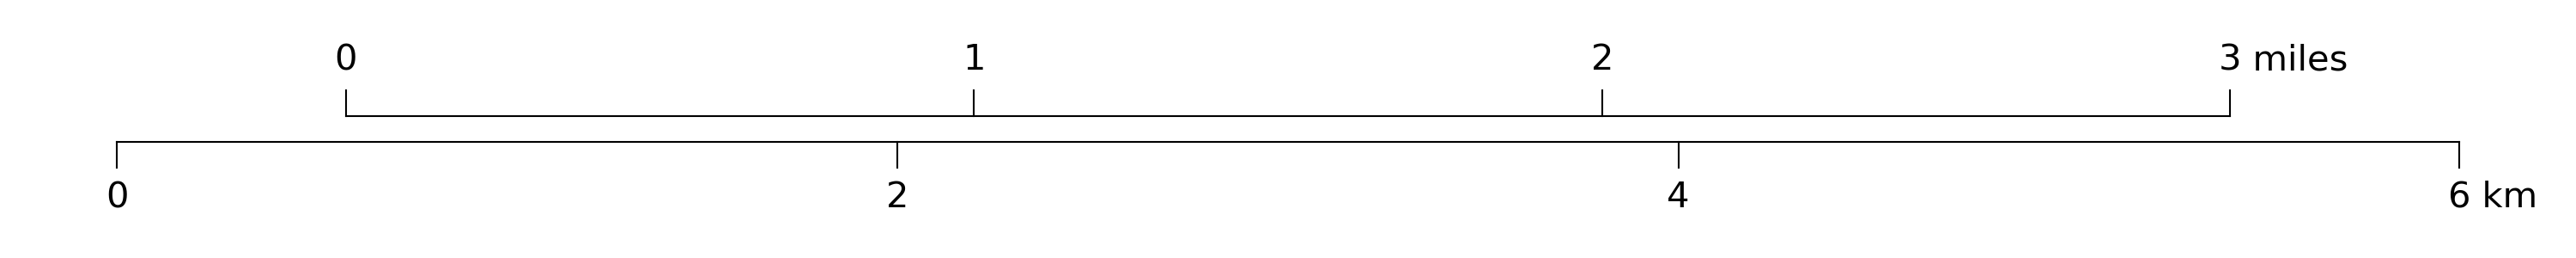

In [158]:
foo = make_scalebar(4,1,2,1)
display(foo)
foo = make_scalebar(2,1,2,1)
display(foo)

print("3 meters across 500 pixels")
foo = generate_scalebar_ticks(3, img_width_in_pixels=500, scale_width_ratio=1, min_step_width=100)
display(foo)

print("1000 meters across 500 pixels")
foo = generate_scalebar_ticks(1000, img_width_in_pixels=500, scale_width_ratio=1, min_step_width=100)
display(foo)

print("4999 meters across 500 pixels")
foo = generate_scalebar_ticks(4999, img_width_in_pixels=500, scale_width_ratio=1, min_step_width=100)
display(foo)

print("5000 meters across 500 pixels")
foo = generate_scalebar_ticks(5000, img_width_in_pixels=500, scale_width_ratio=1, min_step_width=100)
display(foo)

print("6000 meters across 500 pixels")
foo = generate_scalebar_ticks(6000, img_width_in_pixels=500, scale_width_ratio=1, min_step_width=100)
display(foo)